# Diffraction d'une Source Polychromatique

## 1. Efficacité quantique du capteur KAF-8300

- **Type de capteur** : CCD (charge-coupled device).
- **Format** : Four Thirds, avec une diagonale de 22.5$\text{mm}$.
- **Applications** : Conçu pour des performances élevées dans diverses applications de capture d'images, qu'elles soient en couleur ou en monochrome.
- **Pixels** : Chaque pixel a une dimension de 5.4$\mu \text{m}^2$.
- **Matrice de Bayer** : Utilisation d'une matrice RGB pour chaque photosite (On suppose dans nôtre cas que ça n'impacte pas la fréquence d'échantillonnage). 
- **Microlentilles** : Microlentilles superposées pour améliorer la réponse et la reproduction des couleurs dans la version couleur.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

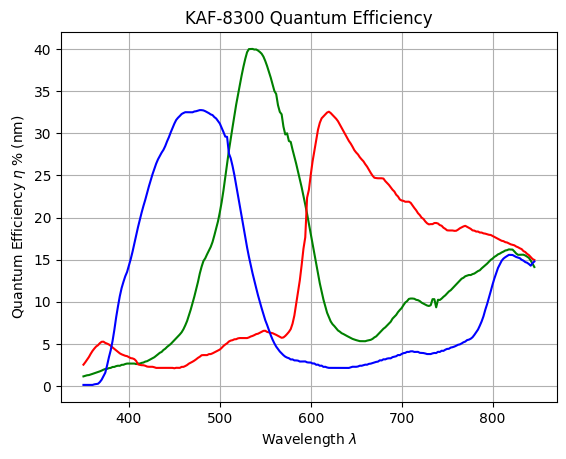

In [2]:
data_g = np.loadtxt('Green-KAF-8300.dat')
data_b = np.loadtxt('Blue-KAF-8300.dat')
data_r = np.loadtxt('Red-KAF-8300.dat')

xg = data_g[:, 0]
yg = data_g[:, 1]
yr = data_r[:, 1]
yb = data_b[:, 1]

plt.plot(xg, yg, color='g')
plt.plot(xg, yr, color='r')
plt.plot(xg, yb, color='b')

plt.xlabel(r"Wavelength $\lambda$")
plt.ylabel(r"Quantum Efficiency $\eta\;$% (nm)")
plt.title('KAF-8300 Quantum Efficiency')
plt.grid(True)
plt.show()

## 2. Obturateur Rectangulaire

### 2.1 Cas d'une Onde Monochromatique

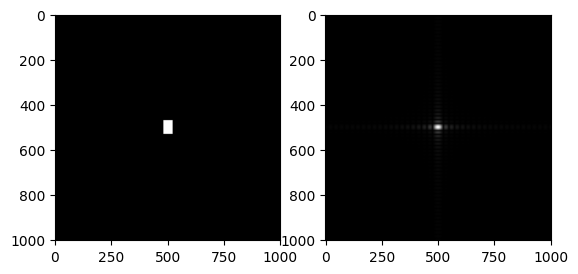

In [3]:
a = 40
b = 60 

x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)

grating = np.zeros_like(X)
mask = (np.abs(X) <= a / 2) & (np.abs(Y) <= b / 2)
grating[mask] = 1

plt.subplot(121)
plt.set_cmap("gray")
plt.imshow(grating)

ft = np.fft.fftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122) 
plt.imshow(abs(ft))

plt.show()

### 2.2 Cas d'une Onde Polychromatique

#### 2.2.1 Changement de variable

La transformée de fourier effectuée est en fonction des fréquences spaciales $\,u\,$ et $\,v\,$ sachant qu'on a :
$$ u \;=\; \dfrac{\theta_X}{\lambda}\hspace{20mm} v\;=\; \dfrac{\theta_Y}{\lambda}$$
On choisit alors une longeur d'onde de référence (ici prise $\;\lambda_{\texttt{ref}}=600\;\text{nm}\;$) et pour chaque autre longeur d'onde on définit :
$$ \sigma_\lambda \; = \; \dfrac{\lambda_{\texttt{ref}}}{\lambda} $$
Dans le cas d'une fente nous avons la TF de la transmittance :
$$\begin{array}
da\,\text{sinc}\left(\pi a u\right)\times b\,\text{sinc}\left(\pi b v\right) &\;=\;& ab \; \text{sinc}\left(\pi a \sigma_\lambda u_{\texttt{ref}} \right)\text{sinc}\left(\pi b \sigma_\lambda v_{\texttt{ref}} \right) \\
&\;=\;& \dfrac{\alpha\beta}{\sigma_\lambda^2}\;\text{sinc}\left(\pi \alpha u_{\texttt{ref}} \right)\text{sinc}\left(\pi \beta v_{\texttt{ref}} \right)
\end{array}$$

In [4]:
wavelength_ref = 600
wavelength = np.arange(400, 820, 10)
sigma = wavelength_ref / wavelength

In [5]:
alpha = a * sigma
beta = b * sigma

Red_Img = np.zeros_like(X, dtype=np.float64)
Blue_Img = np.zeros_like(X, dtype=np.float64)
Green_Img = np.zeros_like(X, dtype=np.float64)

for i, wl in enumerate(wavelength):
    grating = np.zeros_like(X)
    mask = (np.abs(X) <= alpha[i] / 2) & (np.abs(Y) <= beta[i] / 2)
    grating[mask] = 1

    ft = np.fft.fftshift(grating)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    index = np.unravel_index(np.argmax(xg == wl), xg.shape)
    
    silly_coeff = (100 * sigma[i]**2 * a * b)
    Red_Img += yr[index] / silly_coeff * np.abs(ft)
    Blue_Img += yb[index] / silly_coeff * np.abs(ft)
    Green_Img += yg[index] / silly_coeff * np.abs(ft)

Red_Img = 255 * Red_Img
Blue_Img = 255 * Blue_Img
Green_Img = 255 * Green_Img 

Red_Img = Red_Img.astype(int)
Blue_Img = Blue_Img.astype(int)
Green_Img = Green_Img.astype(int)

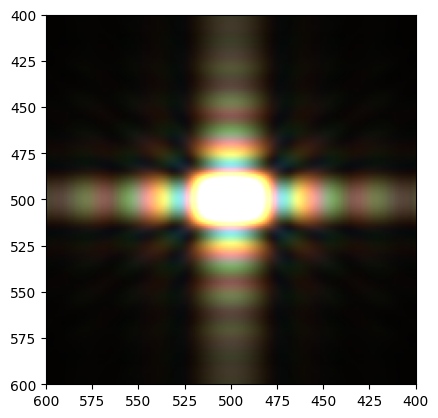

In [6]:
RGB_Image = np.stack([Red_Img, Green_Img, Blue_Img], axis=-1)
RGB_Image = np.clip(RGB_Image, 0, 255)  

plt.imshow(RGB_Image)
plt.xlim([600, 400])
plt.ylim([600, 400])

plt.show()

## 3. Obturateur Circulaire

### 3.1 Cas d'une Onde Monochromatique

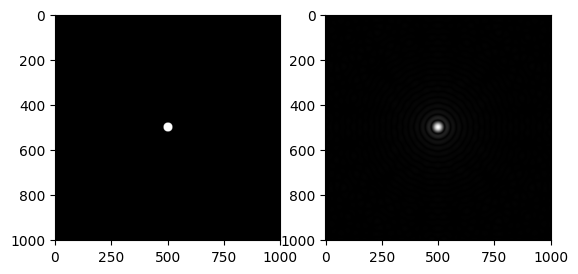

In [7]:
D = 40
center = (0, 0)

grating = np.zeros_like(X)
circle_mask = (X - center[0]) ** 2 + (Y - center[1]) ** 2 <= (D/2) ** 2
grating[circle_mask] = 1

plt.subplot(121)
plt.set_cmap("gray")
plt.imshow(grating)

ft = np.fft.fftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122) 
plt.imshow(abs(ft))

plt.show()

### 3.2 Cas d'une Onde Polychromatique

De la même manière on sait que la transformée de Fourier de la transmittance de l'objet circulaire :
$$\dfrac{\pi D^2}{4} \dfrac{2J_0(\pi\rho D)}{\pi\rho D}$$
Avec $\,J_0\,$ la première fonction de Bessel de première espèce.
$$\rho \;=\; \dfrac{\theta}{\lambda} \hspace{15mm} \sigma_\lambda \; = \; \dfrac{\lambda_{\texttt{ref}}}{\lambda}$$
On aura :
$$\begin{array}{rcl}
\dfrac{\pi D^2}{4} \dfrac{2J_0(\pi\rho D)}{\pi\rho D} &\;=\;& \dfrac{\pi D^2}{4} \dfrac{2J_0(\pi\sigma_\lambda\rho_{\texttt{ref}} D)}{\pi\sigma_\lambda\rho_{\texttt{ref}} D}\\
&\;=\;& \dfrac{\pi D^2}{4} \dfrac{2J_0(\pi \rho_{\texttt{ref}} \Delta)}{\pi\rho_{\texttt{ref}} \Delta}\\
&\;=\;& \dfrac{\pi \Delta^2}{4 \sigma_\lambda^2} \dfrac{2J_0(\pi \rho_{\texttt{ref}} \Delta)}{\pi\rho_{\texttt{ref}} \Delta}\\
\end{array}$$

In [8]:
Delta = D * sigma

Red_Img = np.zeros_like(X, dtype=np.float64)
Blue_Img = np.zeros_like(X, dtype=np.float64)
Green_Img = np.zeros_like(X, dtype=np.float64)

for i, wl in enumerate(wavelength):
    grating = np.zeros_like(X)
    circle_mask = (X - center[0]) ** 2 + (Y - center[1]) ** 2 <= (Delta[i] / 2 )**2
    grating[circle_mask] = 1   

    ft = np.fft.fftshift(grating)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    index = np.unravel_index(np.argmax(xg == wl), xg.shape)
    
    silly_coeff = (100 * sigma[i]**2 * (D/2)**2 * 4 / np.pi)
    Red_Img += yr[index] / silly_coeff * np.abs(ft)
    Blue_Img += yb[index] / silly_coeff * np.abs(ft)
    Green_Img += yg[index] / silly_coeff * np.abs(ft)

Red_Img = 255 * Red_Img
Blue_Img = 255 * Blue_Img
Green_Img = 255 * Green_Img 

Red_Img = Red_Img.astype(int)
Blue_Img = Blue_Img.astype(int)
Green_Img = Green_Img.astype(int)

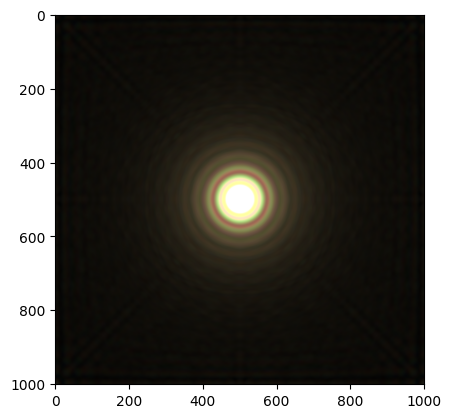

In [9]:
RGB_Image = np.stack([Red_Img, Green_Img, Blue_Img], axis=-1)
RGB_Image = np.clip(RGB_Image, 0, 255)  

plt.imshow(RGB_Image)
# plt.xlim([300, 700])
# plt.ylim([300, 700])

plt.show()

## 4. Réseau

### 4.1 Cas d'une Onde Monochromatique

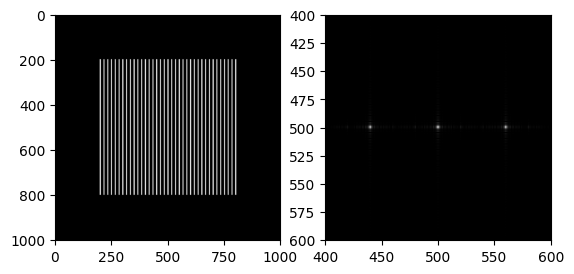

In [10]:
a = 4   
N = 36 
lenWindow = 600
d = lenWindow / N

x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)

grating = np.zeros_like(X)
for i in range(- N // 2, N // 2 + 1):
    x_offset = i * d
    mask = (np.abs(X - x_offset) <= a / 2) & (np.abs(Y) <= lenWindow / 2)
    grating[mask] = 1

plt.subplot(121)
plt.set_cmap("gray")
plt.imshow(grating)

ft = np.fft.fftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122) 
plt.imshow(abs(ft))
plt.xlim([400, 600]) 
plt.ylim([600, 400])

plt.show()

### 4.2 Cas d'une Onde Polychromatique

De la même manière on sait que la transformée de Fourier de la transmittance du réseau :
$$ a\,\text{sinc}\left(\pi u a\right) \dfrac{\sin\left(\pi u Nd\right)}{\sin\left(\pi u d\right)} \,\delta(v)$$
En premier lieu on a : 
$$u \;=\; \dfrac{\theta_X}{\lambda} \hspace{15mm} v \;=\; \dfrac{\theta_Y}{\lambda} \hspace{15mm} \sigma_\lambda \; = \; \dfrac{\lambda_{\texttt{ref}}}{\lambda}$$
On effectue le changement de variable : 
$$\begin{array}{rcl}
a\,\text{sinc}\left(\pi u a\right) \dfrac{\sin\left(\pi u Nd\right)}{\sin\left(\pi u d\right)}\,\delta(v) &\;=\;& a\,\text{sinc}\left(\pi \sigma_\lambda u_{\texttt{ref}} a\right) \dfrac{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} Nd\right)}{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} d\right)} \,\delta(v) \\
&\;=\;& \dfrac{\alpha}{\sigma_\lambda}\,\text{sinc}\left(\pi u_{\texttt{ref}} \alpha\right) \dfrac{\sin\left(\pi u_{\texttt{ref}} N\delta\right)}{\sin\left(\pi u_{\texttt{ref}} \delta\right)} \,\delta(v)
\end{array}$$

In [11]:
alpha = a * sigma
delta = d * sigma

Red_Img = np.zeros_like(X, dtype=np.float64)
Blue_Img = np.zeros_like(X, dtype=np.float64)
Green_Img = np.zeros_like(X, dtype=np.float64)

for j, wl in enumerate(wavelength):
    grating = np.zeros_like(X)
    for i in range(-N // 2, N // 2 + 1):
        x_offset = i * delta[j]
        mask = (np.abs(X - x_offset) <= alpha[j] / 2) & (np.abs(Y) <= lenWindow / 2)
        grating[mask] = 1

    ft = np.fft.fftshift(grating)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    index = np.unravel_index(np.argmax(xg == wl), xg.shape)
    
    silly_coeff = (100 * sigma[j]**2 * a * N * lenWindow)
    Red_Img += yr[index] / silly_coeff * np.abs(ft)
    Blue_Img += yb[index] / silly_coeff * np.abs(ft)
    Green_Img += yg[index] / silly_coeff * np.abs(ft)

Red_Img = 255 * Red_Img 
Blue_Img = 255 * Blue_Img 
Green_Img = 255 * Green_Img 

Red_Img = Red_Img.astype(int)
Blue_Img = Blue_Img.astype(int)
Green_Img = Green_Img.astype(int)

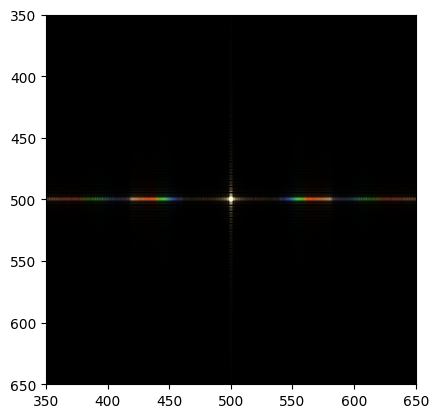

In [12]:
RGB_Image = np.stack([Red_Img, Green_Img, Blue_Img], axis=-1)
RGB_Image = np.clip(RGB_Image, 0, 255)  

plt.imshow(RGB_Image)
plt.xlim([350, 650]) 
plt.ylim([650, 350])

plt.show()

### 4.3 Loi des Réseaux

La condition pour des interférences constructives dans un réseau de diffraction avec une onde incidente de longueur d'onde $\,\lambda\,$ est donnée par l'équation :
$$d \cdot (\sin \theta_i + \sin \theta_m) \;=\; m \cdot \lambda
$$
Où :  
- $d\,$ est le pas du réseau, 
- $\theta_i\,$ est l'angle d'incidence, 
- $\theta_m\,$ est l'angle de réfraction pour lequel les interférences sont constructives
- m est un nombre entier.

In [13]:
from TP3_DiffractionOrder import DiffractionOrder

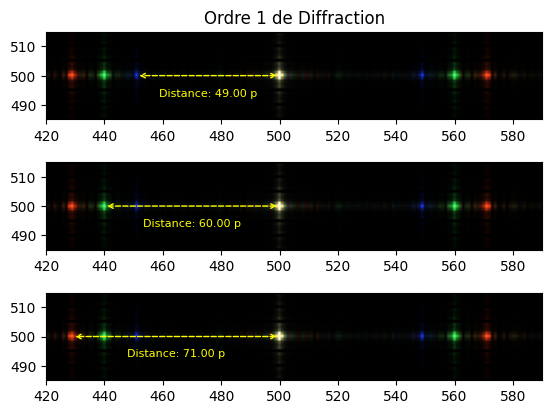

In [14]:
diffraction_order = DiffractionOrder('Green-KAF-8300.dat', 'Blue-KAF-8300.dat', 'Red-KAF-8300.dat')
diffraction_order.calculate_rgb_image()
diffraction_order.plot_all()

Dans notre cas on suppose que l'incidence est normale est que les angles $\,\theta_m\,$ ne sont pas trop éloignés de la normale, l'équation devient :
$$ \theta_m \;=\; \dfrac{m \cdot \lambda}{d}$$
$$ \texttt{nb_pixels} \cdot \theta_e \;=\; \dfrac{m \cdot \lambda}{d}$$
Où :
- $\texttt{nb_pixels}\;$est la distance en pixels entre l'ordre $0$ et l'ordre $\,m\,$ de diffraction.
- $\theta_e\;$ est l'angle d'échantillonnage.

Donc pour 2 longeurs d'ondes différentes on a :
$$\dfrac{\texttt{nb_pixels1}}{\texttt{nb_pixels2}} \;=\; \dfrac{\lambda_1}{\lambda_2}$$

In [15]:
dist_ord1 = diffraction_order.dist_order1[::-1]
wl = diffraction_order.wavelengths[::-1]
for i in range(len(wl)-1):
    print(f"lambda1\t=\t{wl[i+1]}\tnm\nlambda2\t=\t{wl[0]}\tnm\n")
    print(f"nb_pixels1/nb_pixels2\t=\t{dist_ord1[i+1]/dist_ord1[0]}")
    print(f"lambda1/lambda2\t=\t{wl[i+1]/wl[0]}\n")

lambda1	=	540	nm
lambda2	=	640	nm

nb_pixels1/nb_pixels2	=	0.8450704225352113
lambda1/lambda2	=	0.84375

lambda1	=	440	nm
lambda2	=	640	nm

nb_pixels1/nb_pixels2	=	0.6901408450704225
lambda1/lambda2	=	0.6875



## 5. Superposition de 2 Réseaux

### 5.1 Cas d'une Onde Monochromatique

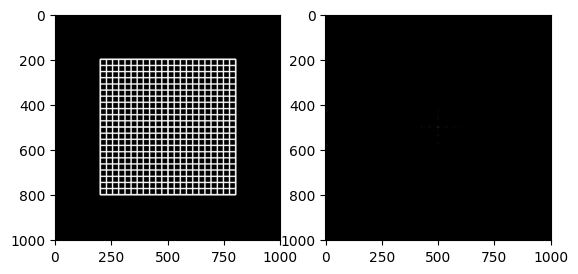

In [16]:
a = 6
N = 22 
lenWindow = 600
d = lenWindow / N

x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)

grating = np.zeros_like(X)

for i in range(-N // 2, N // 2 + 1):
    x_offset = i * d
    mask = (np.abs(X - x_offset) <= a / 2) & (np.abs(Y) <= lenWindow / 2)
    grating[mask] = 1
for i in range(-N // 2, N // 2 + 1):
    y_offset = i * d
    mask = (np.abs(Y - y_offset) <= a / 2) & (np.abs(X) <= lenWindow / 2)
    grating[mask] = 1

plt.subplot(121)
plt.set_cmap("gray")
plt.imshow(grating)

ft = np.fft.fftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122) 
plt.imshow(abs(ft))

plt.show()

### 5.2 Cas d'une Onde Polychromatique

De la même manière on sait que la transformée de Fourier de la transmittance des 2 réseaux :
$$ a^2\,\text{sinc}\left(\pi u a\right)\text{sinc}\left(\pi v a\right) \dfrac{\sin\left(\pi u Nd\right)}{\sin\left(\pi u d\right)} \dfrac{\sin\left(\pi v Nd\right)}{\sin\left(\pi v d\right)}$$
En premier lieu on a : 
$$u \;=\; \dfrac{\theta_X}{\lambda} \hspace{15mm} v \;=\; \dfrac{\theta_Y}{\lambda} \hspace{15mm} \sigma_\lambda \; = \; \dfrac{\lambda_{\texttt{ref}}}{\lambda}$$
On effectue le changement de variable : 
$$\begin{array}{rcl}
a^2\,\text{sinc}\left(\pi u a\right)\text{sinc}\left(\pi v a\right) \dfrac{\sin\left(\pi u Nd\right)}{\sin\left(\pi u d\right)} \dfrac{\sin\left(\pi v Nd\right)}{\sin\left(\pi v d\right)} &\;=\;& a^2\,\text{sinc}\left(\pi \sigma_\lambda u_{\texttt{ref}} a\right)\text{sinc}\left(\pi \sigma_\lambda v_{\texttt{ref}} a\right) \dfrac{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} Nd\right)}{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} d\right)}\dfrac{\sin\left(\pi \sigma_\lambda v_{\texttt{ref}} Nd\right)}{\sin\left(\pi \sigma_\lambda v_{\texttt{ref}} d\right)} \\
&\;=\;& \dfrac{\alpha^2}{\sigma_\lambda^2}\,\text{sinc}\left(\pi u_{\texttt{ref}} \alpha\right)\text{sinc}\left(\pi v_{\texttt{ref}} \alpha\right) \dfrac{\sin\left(\pi u_{\texttt{ref}} N\delta\right)}{\sin\left(\pi u_{\texttt{ref}} \delta\right)} \dfrac{\sin\left(\pi v_{\texttt{ref}} N\delta\right)}{\sin\left(\pi v_{\texttt{ref}} \delta\right)}
\end{array}$$

In [17]:
alpha = a * sigma
delta = d * sigma

Red_Img = np.zeros_like(X, dtype=np.float64)
Blue_Img = np.zeros_like(X, dtype=np.float64)
Green_Img = np.zeros_like(X, dtype=np.float64)

for j, wl in enumerate(wavelength):
    grating = np.zeros_like(X)
    for i in range(-N // 2, N // 2 + 1):
        x_offset = i * delta[j]
        mask = (np.abs(X - x_offset) <= alpha[j] / 2)
        grating[mask] = 1
    for i in range(-N // 2, N // 2 + 1):
        y_offset = i * delta[j]
        mask = (np.abs(Y - y_offset) <= alpha[j] / 2)
        grating[mask] = 1

    ft = np.fft.fftshift(grating)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    index = np.unravel_index(np.argmax(xg == wl), xg.shape)
    
    silly_coeff = (100 * sigma[j]**2 * a**2 * N**2)
    Red_Img += yr[index] / silly_coeff * np.abs(ft)
    Blue_Img += yb[index] / silly_coeff * np.abs(ft)
    Green_Img += yg[index] / silly_coeff * np.abs(ft)

Red_Img = 255 * Red_Img 
Blue_Img = 255 * Blue_Img  
Green_Img = 255 * Green_Img 

Red_Img = Red_Img.astype(int)
Blue_Img = Blue_Img.astype(int)
Green_Img = Green_Img.astype(int)

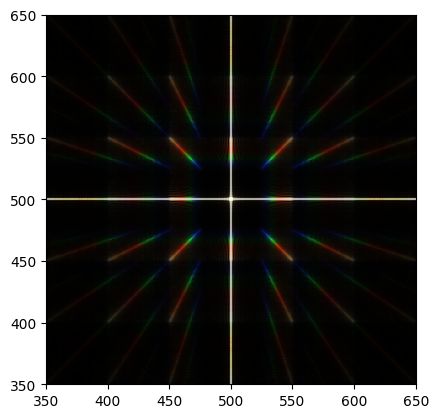

In [18]:
RGB_Image = np.stack([Red_Img, Green_Img, Blue_Img], axis=-1)
RGB_Image = np.clip(RGB_Image, 0, 255)  

plt.imshow(RGB_Image)
# plt.xlim([450, 520])
# plt.ylim([480, 550])
plt.xlim([350, 650])
plt.ylim([350, 650])

plt.show()

## 6. Trellis

### 6.1 Cas d'une Onde Monochromatique

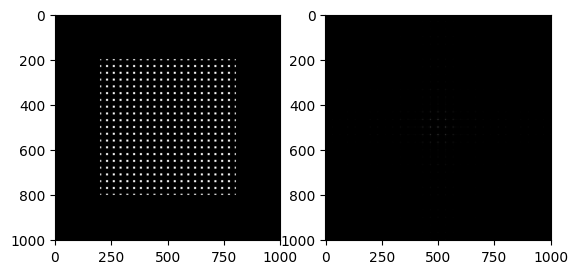

In [19]:
a = 20
d = 10
lenWindow = 600
N = int(lenWindow / (d + a)) 

x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)

grating = np.ones_like(X)

for i in range(-N // 2 - 1, N // 2 + 1):
    x_offset = i * (d + a) - (d + a)/2
    mask = (np.abs(X - x_offset) <= a / 2) | (abs(Y) > lenWindow / 2)
    grating[mask] = 0
for i in range(-N // 2 - 1, N // 2 + 1):
    y_offset = i * (d + a) - (d + a)/2
    mask = (np.abs(Y - y_offset) <= a / 2) | (abs(X) > lenWindow / 2)
    grating[mask] = 0

plt.subplot(121)
plt.set_cmap("gray")
plt.imshow(grating)

ft = np.fft.fftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122) 
plt.imshow(abs(ft))

plt.show()

### 6.2 Cas d'une Onde Polychromatique

De la même manière on sait que la transformée de Fourier de la transmittance du trellis :
$$ d^2\,\text{sinc}\left(\pi u d\right)\text{sinc}\left(\pi v d\right) \dfrac{\sin\left(\pi u Na\right)}{\sin\left(\pi u a\right)} \dfrac{\sin\left(\pi v Na\right)}{\sin\left(\pi v a\right)}$$
En premier lieu on a : 
$$u \;=\; \dfrac{\theta_X}{\lambda} \hspace{15mm} v \;=\; \dfrac{\theta_Y}{\lambda} \hspace{15mm} \sigma_\lambda \; = \; \dfrac{\lambda_{\texttt{ref}}}{\lambda}$$
On effectue le changement de variable : 
$$\begin{array}{rcl}
d^2\,\text{sinc}\left(\pi u d\right)\text{sinc}\left(\pi v d\right) \dfrac{\sin\left(\pi u Na\right)}{\sin\left(\pi u a\right)} \dfrac{\sin\left(\pi v Na\right)}{\sin\left(\pi v a\right)} &\;=\;& d^2\,\text{sinc}\left(\pi \sigma_\lambda u_{\texttt{ref}} d\right)\text{sinc}\left(\pi \sigma_\lambda v_{\texttt{ref}} d\right) \dfrac{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} Na\right)}{\sin\left(\pi \sigma_\lambda u_{\texttt{ref}} a\right)}\dfrac{\sin\left(\pi \sigma_\lambda v_{\texttt{ref}} Na\right)}{\sin\left(\pi \sigma_\lambda v_{\texttt{ref}} a\right)} \\
&\;=\;& \dfrac{\delta^2}{\sigma_\lambda^2}\,\text{sinc}\left(\pi u_{\texttt{ref}} \delta\right)\text{sinc}\left(\pi v_{\texttt{ref}} \delta\right) \dfrac{\sin\left(\pi u_{\texttt{ref}} N\alpha\right)}{\sin\left(\pi u_{\texttt{ref}} \alpha\right)} \dfrac{\sin\left(\pi v_{\texttt{ref}} N\alpha\right)}{\sin\left(\pi v_{\texttt{ref}} \alpha\right)}
\end{array}$$

In [20]:
alpha = a * sigma
delta = d * sigma

Red_Img = np.zeros_like(X, dtype=np.float64)
Blue_Img = np.zeros_like(X, dtype=np.float64)
Green_Img = np.zeros_like(X, dtype=np.float64)

for j, wl in enumerate(wavelength):
    
    grating = np.ones_like(X)
    for i in range(-N // 2 - 1, N // 2 + 1):
        x_offset = i * (delta[j] + alpha[j]) - delta[j] / 2
        mask = (np.abs(X - x_offset) <=  alpha[j] / 2)
        grating[mask] = 0
    for i in range(-N // 2, N // 2 + 1):
        y_offset = i * (delta[j] + alpha[j]) - delta[j]/2
        mask = (np.abs(Y - y_offset) <=  alpha[j] / 2)
        grating[mask] = 0

    ft = np.fft.fftshift(grating)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    index = np.unravel_index(np.argmax(xg == wl), xg.shape)
    
    silly_coeff = (100 * sigma[i]**2 * d**2 * N**2)
    Red_Img += yr[index] / silly_coeff * np.abs(ft)
    Blue_Img += yb[index] / silly_coeff * np.abs(ft)
    Green_Img += yg[index] / silly_coeff * np.abs(ft)

Red_Img = 255 * Red_Img 
Blue_Img = 255 * Blue_Img 
Green_Img = 255 * Green_Img 

Red_Img = Red_Img.astype(int)
Blue_Img = Blue_Img.astype(int)
Green_Img = Green_Img.astype(int)

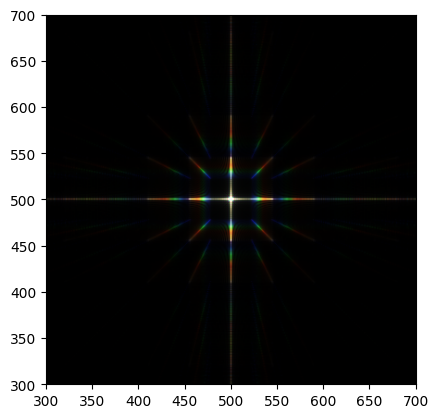

In [21]:
RGB_Image = np.stack([Red_Img, Green_Img, Blue_Img], axis=-1)
RGB_Image = np.clip(RGB_Image, 0, 255)  

plt.imshow(RGB_Image)
# plt.xlim([450, 520])
# plt.ylim([480, 550])
plt.xlim([300, 700])
plt.ylim([300, 700])

plt.show()